In [1]:
#from Node import Control_node 
from Node.Node import Control_node

### Agent
Fields:
`Agent(inputs, behavioral_model, system_estimate, reference, reference_update, sensor_function, comparator_function, controller_update, internal_model_update)`
<br/>
**inputs** - source of inputs (i.e. environment, state observations, others behaviors)
<br/>
**behavioral model** - initial matrix expressing future state given last behavior ("B" matrix)
<br/>
**system estimate** - initial matrix expressing future state given last state ("A" matrix)
<br/>
**reference** - target state 
<br/>
**reference update** - update to reference (target) signal
<br/>
**sensor function** - for taking in (and processing) observations
<br/>
**comparator function** - for comparing observation and estimate
<br/>
**controller** - for generating output
<br/>
**controller update** - for updating the behavioral matrix 
<br/>
**internal model** - for generating forward prediction
<br/>
**internal model update** - for updating the system estimate 
<br/>

![IMC](imc.png)

In [2]:
import numpy as np

In [3]:
# behavioral matrix (maps previous behavior to future behavior commands - how should I behave?)
B1 = np.array([[0.4,0,0],
               [0,0.3,0],
               [0,0,0.2]])
B2 = np.array([[0.1,0,0],
               [0,0.7,0],
               [0,0,0.5]])
# state/system matrix (maps previous state to future state - how will others behave (give past behaviors)?)
A1 = np.array([[0.4,0,0],
               [0,0.4,0],
               [0,0,0.4]])
A2 = np.array([[0.3,0,0],
               [0,0.3,0],
               [0,0,0.3]])
# reference matrix (how do I expect/want others to behave? target values)
R1 = np.array([0.3,0.5,0.1])
R2 = np.array([0.1,0.4,0.8])

# get the state observation (behaviors of others)
def sense(inputs):
    return inputs

# contrast reference with observations (and potentially incorporate predictions from internal model)
def compare(sensory_signal, reference, prediction):
    error = reference - sensory_signal
    return error

# generate a behavior
def control(error, behavioral_model, previous_output):
    #learning_rate = 0.01
    output = behavioral_model @ previous_output
    return output


# adjusts behavioral model to get closer to behavior given 
def control_update(error, behavioral_model, previous_output):
    # LMS algorithm
    learning_rate = 0.01
    behavioral_model = behavioral_model + learning_rate * error * previous_output
    return behavioral_model

# generate predictions on next state
def imc(system_estimate, previous_state, behavioral_model, previous_output):
    # actual estimate
    state = (system_estimate @ previous_state) + (behavioral_model @ previous_output)
    return state

# adjust system estimate to infer observations given my behavior
def imc_update(inputs, system_estimate, previous_behavior, behavioral_model, previous_state, learning_rate):
    # actual estimate
    curr_system_est = (system_estimate @ previous_state) + (behavioral_model @ previous_behavior)
    error = curr_system_est - inputs
    #learning_rate = 0.01
    system_estimate = system_estimate + learning_rate * error * previous_behavior
    return system_estimate
    
# behavior = last observation * behavioral model (like a motor command u)
# output = your behavior * est

In [4]:
agent1 = Control_node(sensor=sense, comparator=compare, control_update=control_update, controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, system_estimate=A1, reference=R1)
agent2 = Control_node(sensor=sense, comparator=compare, control_update=control_update,  controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B2, system_estimate=A2, reference=R2)


In [5]:
trials = 100
time = [n for n in range(trials)]
behavior1 = np.array([0,0,0])
behavior2 = np.array([0,0,0])
agent1_behaviors = []
agent2_behaviors = []
agent1_error = []
agent2_error = []

for t in range(trials):
    b1 = agent1.go(behavior2)
    b2 = agent2.go(behavior1)

    agent1_behaviors.append(agent1.get_output())
    agent2_behaviors.append(agent2.get_output())
    agent1_error.append(sum(abs(agent1.get_error())/len(agent1.get_error())))
    agent2_error.append(sum(abs(agent2.get_error())/len(agent2.get_error())))

    behavior1 = b1
    behavior2 = b2


In [6]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sp
import itertools as it

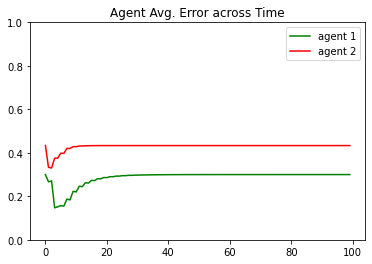

In [7]:
plt.figure(facecolor='white') 
plt.plot(time, agent1_error, 'g', label="agent 1")
plt.plot(time, agent2_error, 'r', label="agent 2")
plt.ylim([0, 1])
plt.legend()
plt.title("Agent Avg. Error across Time")
plt.show()

In [72]:
# behavioral matrix (maps previous behavior to future behavior commands - how should I behave?)
B1 = np.array([[0.4,0,0],
               [0,0.3,0],
               [0,0,0.2]])
B2 = np.array([[0.1,0,0],
               [0,0.7,0],
               [0,0,0.5]])
# state/system matrix (maps previous state to future state - how will others behave (give past behaviors)?)
A1 = np.array([[0.4,0,0],
               [0,0.4,0],
               [0,0,0.4]])
A2 = np.array([[0.3,0,0],
               [0,0.3,0],
               [0,0,0.3]])
# reference matrix (how do I expect/want others to behave? target values)
R1 = np.array([0.3,0.5,0.1])
R2 = np.array([0.1,0.4,0.8])


def dynamic_sigmoid(i, x):
    '''
    Helper sigmoid function where the intercept is a value of i (list)
    '''
    y = np.exp(np.clip(-x, -100, 100))  # avoid runover into infinity.
    out = np.asarray([1 / (1 + ((1 - np.clip(i[j], 1e-50, 1-1e-50))/np.clip(i[j], 1e-50, 1-1e-50)) * y[j])
                      for j in range(len(i))])  # changed clips to keep sigmoid function from getting stuck at 0 or 1
    return out
    

# get the state observation (behaviors of others)
def sense(inputs):
    return inputs

# contrast reference with observations (and potentially incorporate predictions from internal model)
def compare(sensory_signal, reference, prediction):
    error = prediction - sensory_signal
    pred_error = sum(abs(error))
    threshold = 0.1
    if pred_error > threshold:
            magnitude = np.random.choice([-1, 1]) * pred_error
            r = round(np.random.uniform(0, magnitude), 3) * threshold
            error = np.array([e*r for e in error])
    return error

# generate a behavior
def control(error, behavioral_model, previous_output):
    output = dynamic_sigmoid(previous_output, error)
    return output


# adjusts behavioral model to get closer to behavior given 
def control_update(error, behavioral_model, previous_output):
    # LMS algorithm
    #learning_rate = 0.01
    #behavioral_model = behavioral_model + learning_rate * error * previous_output
    return behavioral_model

# generate predictions on next state
def imc(system_estimate, previous_state, behavioral_model, previous_output):
    # actual estimate
    #state = (system_estimate @ previous_state) + (behavioral_model @ previous_output)
    return np.array([0,0,0])

# adjust system estimate to infer observations given my behavior
def imc_update(inputs, system_estimate, previous_behavior, behavioral_model, previous_state, learning_rate):
    # actual estimate
    #curr_system_est = (system_estimate @ previous_state) + (behavioral_model @ previous_behavior)
    #error = curr_system_est - inputs
    #learning_rate = 0.01
    #system_estimate = system_estimate + learning_rate * error * previous_behavior
    return system_estimate
    
# behavior = last observation * behavioral model (like a motor command u)
# output = your behavior * est

In [73]:
agent1 = Control_node(sensor=sense, comparator=compare, control_update=control_update, controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, system_estimate=A1, reference=R1)
agent2 = Control_node(sensor=sense, comparator=compare, control_update=control_update,  controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B2, system_estimate=A2, reference=R2)


In [74]:
trials = 100
time = [n for n in range(trials)]
behavior1 = np.array([0,1,0])
behavior2 = np.array([1,0,1])
agent1_behaviors = []
agent2_behaviors = []
agent1_error = []
agent2_error = []

for t in range(trials):
    b1 = agent1.go(behavior2)
    b2 = agent2.go(behavior1)

    agent1_behaviors.append(agent1.get_output())
    agent2_behaviors.append(agent2.get_output())
    agent1_error.append(sum(abs(agent1.get_error())/len(agent1.get_error())))
    agent2_error.append(sum(abs(agent2.get_error())/len(agent2.get_error())))

    behavior1 = b1
    behavior2 = b2


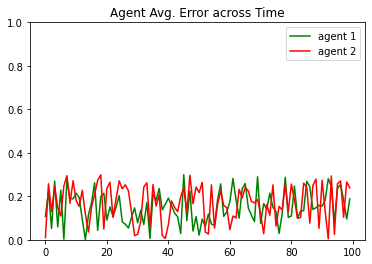

In [75]:
plt.figure(facecolor='white') 
plt.plot(time, agent1_error, 'g', label="agent 1")
plt.plot(time, agent2_error, 'r', label="agent 2")
plt.ylim([0, 1])
plt.legend()
plt.title("Agent Avg. Error across Time")
plt.show()